# Application benchmarks: single node performance comparison

Comparison the single-node performance of three different application benchmarks across a variety of architectures.

## Import required modules for results analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,6)
import seaborn as sns
sns.set_style("white", {"font.family": "serif"})
from scipy import stats
marker_a = ['x','o','^','+','d','s','v']

In [2]:
import sys
sys.path.append('../python-modules')
from utilities import filemanip, sysinfo

## System details

In [3]:
sysdetails = sysinfo.getdetails('../systems.yaml')

## Peak floating point performance

In this section we calculate the peak floating point performance for each of the systems. CPU FLOPS are computed as
(number of cores used) * (single precision FLOPS per cycle) * (frequency). See below for values used for the different systems. GPU FLOPS are computed as (number of GPUs used) * (GPU single precision FLOPS reference value
[ref](https://www.nvidia.com/en-us/data-center/tesla-p100/)).

In [4]:
systems = ['ARCHER','Athena','Cirrus','CSD3-Skylake','Isambard','Tesseract','Thomas','CSD3-GPU','JADE']
peak_fp = {}


formath = "{:>15s} {:>20s}"
formatp = "{:>15s} {:>20.1f}"
print("Performance improvement relative to ARCHER:\n")
print(formath.format('System', 'Peak CPU SP FLOP/s'))
print(formath.format('======', '=================='))

# Calculate CPU SP FP performance (GFLOP/s): cores * ops/cycle * freq.
for system in systems:
    sysdict = sysdetails[system]
    peak_fp[system] = sysdict['PCores'] * sysdict['PPerNode'] * sysdict['FLOPS'] * sysdict['PFreq']
    print(formatp.format(sysdict['Name'], peak_fp[system]))


Performance improvement relative to ARCHER:

         System   Peak CPU SP FLOP/s
         ======   ==================
         ARCHER               1036.8
         Athena               2150.4
         Cirrus               2419.2
  Peta4-Skylake               5324.8
       Isambard               2252.8
      Tesseract               1612.8
         Thomas               1612.8
    Wilkes2-GPU                844.8
           JADE               3072.0


## Peak memory performance
We define the peak memory performance both in terms of the peak bandwidth measured using the StarSTREAM Triad benchmark (part of the HPC Challenge suite) and in terms of the number of memory channels available per socket. Note, these values are for the CPU systems only.

In [5]:
# Per-core memory bandwidth from StarSTREAM Triad (GB/s)
peak_bw = {}
peak_bw['ARCHER'] = 3.036
peak_bw['Athena'] = 3.304
peak_bw['CSD3-Skylake'] = 4.508
peak_bw['Cirrus'] = 2.718
peak_bw['Isambard'] = 3.461
peak_bw['Tesseract'] = 5.181
peak_bw['Thomas'] = 5.181


# Per-socket memory channels
systems = ['ARCHER','Athena','Cirrus','CSD3-Skylake','Isambard','Tesseract','Thomas','CSD3-GPU','JADE']
channels = {}

formath = "{:>15s} {:>20s}"
formatp = "{:>15s} {:>20d}"
print("Performance improvement relative to ARCHER:\n")
print(formath.format('System', 'Memory Channels'))
print(formath.format('======', '==============='))

for system in systems:
    sysdict = sysdetails[system]
    channels[system] = sysdict['MChannels']
    print(formatp.format(sysdict['Name'], channels[system]))


Performance improvement relative to ARCHER:

         System      Memory Channels
         ======      ===============
         ARCHER                    4
         Athena                    4
         Cirrus                    4
  Peta4-Skylake                    6
       Isambard                    8
      Tesseract                    6
         Thomas                    4
    Wilkes2-GPU                    4
           JADE                    4


## GROMACS: 1400k Atom Benchmark

Details of the 1400k benchmark can be found in this repository at:  https://github.com/hpc-uk/archer-benchmarks/tree/master/apps/GROMACS

Performance is measured in 'ns/day'. This is calculated by the GROMACS software itself and is read directly from the GROMACS output.

In [20]:
from appanalysis import gromacs

### Best performance per platform comparison


This section compares the best performaning configuration on a single node of each platform.

In [22]:
systems = ['ARCHER','Athena','Cirrus','CSD3-Skylake','Isambard','Tesseract','Thomas','CSD3-GPU']
perf = {}
notes = {}

for system in systems:
    wdir = '../apps/GROMACS/1400k-atoms/results/' + system
    filelist = filemanip.get_filelist(wdir, 'benchmark_1nodes')
    sysdict = sysdetails[system]
    print('\n============================================================')
    print(sysdict['Name'])
    gromacs_df = pd.DataFrame(gromacs.create_df_list(filelist, sysdict['PCores']*sysdict['PPerNode']))
    nodes, perf_max = gromacs.get_perf_stats(gromacs_df, 'max', writestats=True)
    perf[system] = perf_max[0]
    print('\n============================================================')

notes['ARCHER'] = '(24 tasks, 2 threads)'
notes['CSD3-Skylake'] = '(32 tasks, 1 thread)'
notes['Cirrus'] = '(36 tasks, 2 threads)'
notes['Isambard'] = '(128 tasks, 2 threads)'
notes['Tesseract'] = '(24 tasks, 2 threads)'
notes['CSD3-GPU'] = '(4 MPI tasks, 3 OMP per task, 4 GPU)'

# JADE performance result is taken from the runs by HEC BioSim
systems.append('JADE')
perf['JADE'] = 1.647
notes['JADE'] = '(5 core, 1 GPU), http://www.hecbiosim.ac.uk/jade-benchmarks'



ARCHER
                      Perf                      Count
                       min median    max   mean   sum
Nodes Cores Threads                                  
1     24    1        1.025  1.037  1.049  1.037     2
      48    2        1.216  1.216  1.216  1.216     1


Peta4-Skylake
                      Perf                         Count
                       min median    max      mean   sum
Nodes Cores Threads                                     
1     32    1        2.082  2.481  2.492  2.351667     3


Cirrus
                      Perf                         Count
                       min median    max      mean   sum
Nodes Cores Threads                                     
1     36    1        1.632  1.632  1.636  1.633333     3
      72    2        1.699  1.799  1.899  1.799000     2


Isambard
                      Perf                        Count
                       min  median    max    mean   sum
Nodes Cores Threads                                    
1    

In [23]:
systems = ['ARCHER','Athena','Cirrus','CSD3-Skylake','Isambard','Tesseract','Thomas','CSD3-GPU','JADE']

# Add appropriate GPU FP performance for GPU systems
peak_fp['CSD3-GPU'] = peak_fp['CSD3-GPU'] + (4 * sysdetails['CSD3-GPU']['AFLOPs'])
peak_fp['JADE'] = peak_fp['JADE'] + (1 * sysdetails['JADE']['AFLOPs'])


formath = "{:>15s} {:>15s} {:>15s}"
formatp = "{:>15s} {:>15.3f} {:>15.3f} {:s}"
print("Performance improvement relative to ARCHER:\n")
print(formath.format('System', 'Perf. (ns/day)', 'Improvement'))
print(formath.format('======', '==============', '==========='))
gmx_perf_a = []
fp_perf_a = []
gmx_bw_a = []
peak_bw_a = []
channels_a = []
for system in systems:
    sysdict = sysdetails[system]
    tperf = perf.get(system,0.0)
    print(formatp.format(sysdict['Name'], tperf, tperf/perf['ARCHER'], notes.get(system, '')))
    if system in peak_fp:
        gmx_perf_a.append(perf.get(system,0.0))
        fp_perf_a.append(peak_fp.get(system,0.0))
    if system in peak_bw:
        gmx_bw_a.append(perf.get(system,0.0))
        peak_bw_a.append(peak_bw.get(system,0.0))
        channels_a.append(channels.get(system,0.0))
    

Performance improvement relative to ARCHER:

         System  Perf. (ns/day)     Improvement
         ======  ==============     ===========
         ARCHER           1.216           1.000 (24 tasks, 2 threads)
  Peta4-Skylake           2.492           2.049 (32 tasks, 1 thread)
         Cirrus           1.899           1.562 (36 tasks, 2 threads)
       Isambard           1.250           1.028 (128 tasks, 2 threads)
      Tesseract           1.323           1.088 (24 tasks, 2 threads)
    Wilkes2-GPU           2.744           2.257 (4 MPI tasks, 3 OMP per task, 4 GPU)
           JADE           1.647           1.354 (5 core, 1 GPU), http://www.hecbiosim.ac.uk/jade-benchmarks


### Correlation to peak floating point performance

Below we compute the correlation coefficients for the GROMACS benchmark performance compared to peak floating point performance. We perform two correlation tests: a Pearson correlation test to measure the correlation between numerical floating point performance and GROMACS performance; and a Spearman rank-order correlation test to measure the correlation between the order of floating point performance and GROMACS performance.

Pearson correlation coefficient =  0.712
Spearman rank-order correlation coefficient =  0.857


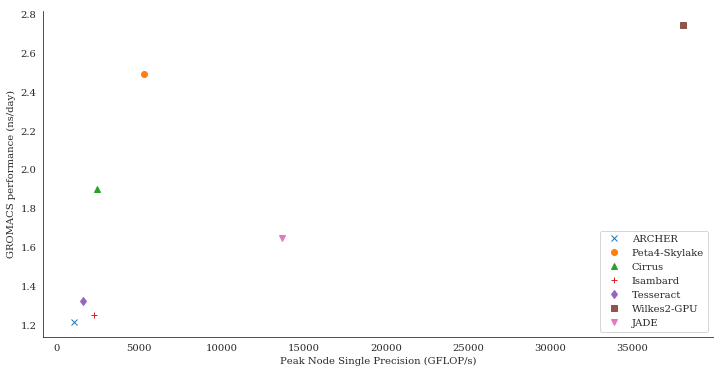

In [24]:
n=0
for system in systems:
    if system in peak_fp:
        plt.plot(peak_fp.get(system,0.0),perf.get(system,0.0),marker_a[n],label=sysdetails[system]['Name'])
        n += 1
plt.xlabel('Peak Node Single Precision (GFLOP/s)')
plt.ylabel('GROMACS performance (ns/day)')
plt.legend(loc='best')
sns.despine()
plt.savefig('gromacs_corr.png', dpi=300)
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(gmx_perf_a, fp_perf_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(gmx_perf_a, fp_perf_a)[0]))

Both the Pearson and Spearman rank-order correlation coefficients are high indicating that the GROMACS benchmark performance is strongly correlated to single preciaion floating point performance of the compute resources used.

#### CPU systems only
Correlation not including GPU systems.

Pearson correlation coefficient =  0.923
Spearman rank-order correlation coefficient =  0.900


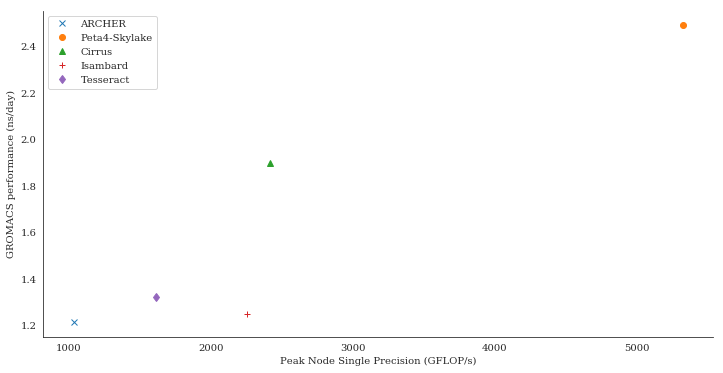

In [25]:
n=0
for system in systems[:-2]:
    if system in peak_fp:
        plt.plot(peak_fp.get(system,0.0),perf.get(system,0.0),marker_a[n],label=sysdetails[system]['Name'])
        n += 1
plt.xlabel('Peak Node Single Precision (GFLOP/s)')
plt.ylabel('GROMACS performance (ns/day)')
plt.legend(loc='best')
sns.despine()
plt.savefig('gromacs_cpu_corr.png', dpi=300)
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(gmx_perf_a[:-2], fp_perf_a[:-2])[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(gmx_perf_a[:-2], fp_perf_a[:-2])[0]))

We can see that if we exclude the GPU systems from the correlation analysis the correlation between performance and floating point performance is even stronger. The Isambard performance is the outlying value as this system does not seem to achieve the GROMACS performance expected from its peak floating point performance.

### Correlation to peak memory performance

Below we compute the correlation coefficients for the GROMACS benchmark performance compared to peak floating point performance. We perform two correlation tests: a Pearson correlation test to measure the correlation between numerical floating point performance and GROMACS performance; and a Spearman rank-order correlation test to measure the correlation between the order of floating point performance and GROMACS performance.

In [26]:
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(gmx_bw_a, peak_bw_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(gmx_bw_a, peak_bw_a)[0]))

Pearson correlation coefficient =  -0.413
Spearman rank-order correlation coefficient =  -0.200


In [27]:
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(gmx_bw_a, channels_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(gmx_bw_a, channels_a)[0]))

Pearson correlation coefficient =  -0.480
Spearman rank-order correlation coefficient =  -0.105


This analysis confirms that there is no obvious correlation between the GROMACS benchmark performance and the memory performance (in terms of bandwidth or number of memory channels). This is as expected as, for this benchmark, we would not expect GROMACS to be dependent on on memory performance.

### Performance comparison matrix

In [28]:
print("{:13s}".format(''),end='')
for jsystem in systems:
    print("{:>14s}".format(sysdetails[jsystem]['Name']), end='')
print()
for isystem in systems:
    print("{:13s}".format(sysdetails[isystem]['Name']), end='')
    for jsystem in systems:
        print("{:14.3f}".format(perf[isystem]/perf[jsystem]), end='')
    print()

                     ARCHER Peta4-Skylake        Cirrus      Isambard     Tesseract   Wilkes2-GPU          JADE
ARCHER                1.000         0.488         0.640         0.973         0.919         0.443         0.738
Peta4-Skylake         2.049         1.000         1.312         1.994         1.884         0.908         1.513
Cirrus                1.562         0.762         1.000         1.519         1.435         0.692         1.153
Isambard              1.028         0.502         0.658         1.000         0.945         0.456         0.759
Tesseract             1.088         0.531         0.697         1.058         1.000         0.482         0.803
Wilkes2-GPU           2.257         1.101         1.445         2.195         2.074         1.000         1.666
JADE                  1.354         0.661         0.867         1.318         1.245         0.600         1.000


## OpenSBLI: Taylor-Green Vortex 512^3 benchmark

Details of the Taylor-Green Vortex 512^3 benchmark can be found in this repository at: https://github.com/hpc-uk/archer-benchmarks/tree/master/apps/OpenSBLI

Performance is measured in 'interations/s'. The total runtime and number of iterations are read directly from the OpenSBLI ouptut and these are used to compute the number of iterations per second.

In [45]:
from appanalysis import osbli

In [46]:
osbli_systems = ['ARCHER','Peta4-Skylake','Cirrus','Isambard','Tesseract']

### Best performance per platform comparison

This section compares the best performaning configuration on a single node of each platform.

In [47]:
osbli_perf = {}
osbli_perf['ARCHER'] = 1.0 / osbli.gettiming('../apps/OpenSBLI/TGV512ss/results/ARCHER/output_1nodes_201808020923.txt')
osbli_perf['Peta4-Skylake'] = 1.0 / osbli.gettiming('../apps/OpenSBLI/TGV512ss/results/CSD3-Skylake/output_1nodes_20190208.txt')
osbli_perf['Cirrus'] = 1.0 / osbli.gettiming('../apps/OpenSBLI/TGV512ss/results/Cirrus/output_1nodes_201812201536.txt')
osbli_perf['Isambard'] = 1.0 / osbli.gettiming('../apps/OpenSBLI/TGV512ss/results/Isambard/output_1nodes_201808020732.txt')
osbli_perf['Tesseract'] = 1.0 / osbli.gettiming('../apps/OpenSBLI/TGV512ss/results/Tesseract/output_1nodes_201812171437.txt')

In [48]:
formath = "{:>15s} {:>15s} {:>15s}"
formatp = "{:>15s} {:>15.3f} {:>15.3f}"
print("Performance improvement relative to ARCHER:\n")
print(formath.format('System', 'Perf. (iter/s)', 'Improvement'))
print(formath.format('======', '==============', '==========='))
aperf = osbli_perf.get('ARCHER',0.0)
osbli_perf_a = []
fp_perf_a = []
osbli_bw_a = []
peak_bw_a = []
channels_a = []
for system in osbli_systems:
    tperf = osbli_perf.get(system,0.0)
    print(formatp.format(system, tperf, tperf/aperf))
    if system in peak_fp:
        osbli_perf_a.append(osbli_perf.get(system,0.0))
        fp_perf_a.append(peak_fp.get(system,0.0))
    if system in peak_bw:
        osbli_bw_a.append(osbli_perf.get(system,0.0))
        peak_bw_a.append(peak_bw.get(system,0.0))
        channels_a.append(channels.get(system,0.0))

Performance improvement relative to ARCHER:

         System  Perf. (iter/s)     Improvement
         ======  ==============     ===========
         ARCHER           0.100           1.000
  Peta4-Skylake           0.196           1.964
         Cirrus           0.130           1.302
       Isambard           0.178           1.777
      Tesseract           0.097           0.971


### Correlation to peak floating point performance

Below we compute the correlation coefficients for the OpenSBLI benchmark performance compared to peak floating point performance. We perform two correlation tests: a Pearson correlation test to measure the correlation between numerical floating point performance and OpenSBLI performance; and a Spearman rank-order correlation test to measure the correlation between the order of floating point performance and OpenSBLI performance.

Pearson correlation coefficient =  0.828
Spearman rank-order correlation coefficient =  0.800


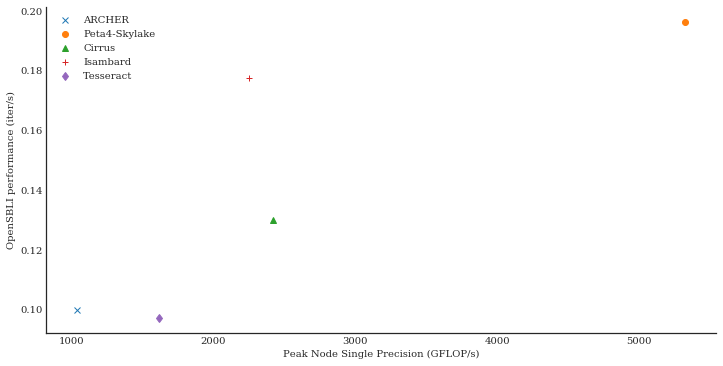

In [49]:
n=0
for system in osbli_systems:
    if system in peak_fp:
        plt.plot(peak_fp.get(system,0.0),osbli_perf.get(system,0.0),marker_a[n],label=system)
        n += 1
plt.xlabel('Peak Node Single Precision (GFLOP/s)')
plt.ylabel('OpenSBLI performance (iter/s)')
plt.legend(loc='best')
sns.despine()
plt.savefig('gromacs_corr.png', dpi=300)
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(osbli_perf_a, fp_perf_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(osbli_perf_a, fp_perf_a)[0]))

This indicates that there is good correlation between OpenSBLI benchmark performance and floating point performance. The main outlier is the Isambard system which sees much greater OpenSBLI performance than we would expect based on its floating point performance alone.

### Correlation to peak memory performance

Below we compute the correlation coefficients for the OpenSBLI benchmark performance compared to memory performance, both in terms of peak bandwdth and in terms of the number of memory channels. As for the floating point correlation analysis, we perform two correlation tests: a Pearson correlation test and a Spearman rank-order correlation test.

In [50]:
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(osbli_bw_a, peak_bw_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(osbli_bw_a, peak_bw_a)[0]))

Pearson correlation coefficient =  0.049
Spearman rank-order correlation coefficient =  -0.100


Pearson correlation coefficient =  0.581
Spearman rank-order correlation coefficient =  0.369


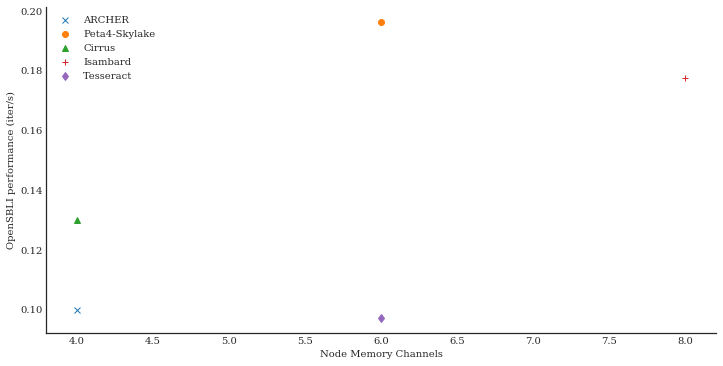

In [51]:
n=0
for system in osbli_systems:
    if system in peak_bw:
        plt.plot(channels.get(system,0.0),osbli_perf.get(system,0.0),marker_a[n],label=system)
        n += 1
plt.xlabel('Node Memory Channels')
plt.ylabel('OpenSBLI performance (iter/s)')
plt.legend(loc='best')
sns.despine()
plt.savefig('osbli_corr.png', dpi=300)
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(osbli_bw_a, channels_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(osbli_bw_a, channels_a)[0]))

These results indicate that there is no real correlation between floating point performance and OpenSBLI benchmark performance.

Looking at the performance data by eye compared to the number of memory channels available on the different processors it appears that if the Tesseract performance is ignored, then there are two performance regimes: 4 memory channels give lower performance and 6 or 8 memory channels give higher performance. The correlation is not strong as the Isambard performance (8 memory channels) is not as high as the Skylake performance (6 memory channels); however, the higher number of memory channels do, in general, lead to higher performance. We can test the level of correlation:

Pearson correlation coefficient =  0.780
Spearman rank-order correlation coefficient =  0.738


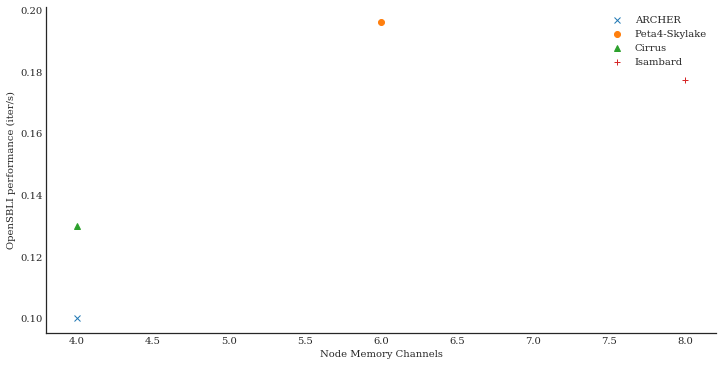

In [52]:
n=0
for system in osbli_systems[:-1]:
    if system in peak_bw:
        plt.plot(channels.get(system,0.0),osbli_perf.get(system,0.0),marker_a[n],label=system)
        n += 1
plt.xlabel('Node Memory Channels')
plt.ylabel('OpenSBLI performance (iter/s)')
plt.legend(loc='best')
sns.despine()
plt.savefig('osbli_corr_notess.png', dpi=300)
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(osbli_bw_a[:-1], channels_a[:-1])[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(osbli_bw_a[:-1], channels_a[:-1])[0]))

The correlation is still not strong but is much stronger than with the Tesseract result included.

### Performance comparison matrix

In [53]:
print("{:13s}".format(''),end='')
for jsystem in osbli_systems:
    print("{:>14s}".format(jsystem), end='')
print()
for isystem in osbli_systems:
    print("{:13s}".format(isystem), end='')
    iperf = osbli_perf[isystem]
    for jsystem in osbli_systems:
        jperf = osbli_perf[jsystem]
        print("{:14.3f}".format(iperf/jperf), end='')
    print()

                     ARCHER Peta4-Skylake        Cirrus      Isambard     Tesseract
ARCHER                1.000         0.509         0.768         0.563         1.030
Peta4-Skylake         1.964         1.000         1.508         1.105         2.022
Cirrus                1.302         0.663         1.000         0.733         1.341
Isambard              1.777         0.905         1.365         1.000         1.830
Tesseract             0.971         0.494         0.746         0.547         1.000


## CASTEP: Al Slab benchmark

Details of the Al Slab benchmark can be found in this repository at:  https://github.com/hpc-uk/archer-benchmarks/blob/master/apps/CASTEP/

Performance is measured in 'mean SCF cycles per second'. This is calculated from the CASTEP output files by computing the SCF cycle times, removing the minimum and maximum value and then computing the mean of the remaining values.

In [54]:
from appanalysis import castep

In [55]:
castep_systems = ['ARCHER','Peta4-Skylake','Cirrus','Isambard','Tesseract']

### Best performance per platform comparison

This section compares the best performaning configuration on a single node of each platform.

In [56]:
castep_perf = {}
castep_perf['ARCHER'] = 1.0 / castep.getmeancycle('../apps/CASTEP/al3x3/results/ARCHER/al3x3.castep.1nodes')
castep_perf['Peta4-Skylake'] = 1.0 / castep.getmeancycle('../apps/CASTEP/al3x3/results/CSD3-Skylake/al3x3.castep.1nodes')
castep_perf['Cirrus'] = 1.0 / castep.getmeancycle('../apps/CASTEP/al3x3/results/Cirrus/17.21_gcc620_impi17/al3x3.castep.1nodes')
castep_perf['Isambard'] = 1.0 / castep.getmeancycle('../apps/CASTEP/al3x3/results/Isambard/al3x3.castep.1nodes_201806130634')
castep_perf['Tesseract'] = 1.0 / castep.getmeancycle('../apps/CASTEP/al3x3/results/Tesseract/al3x3_1nodes_201808071417.castep')

In [57]:
formath = "{:>15s} {:>15s} {:>15s}"
formatp = "{:>15s} {:>15.5f} {:>15.3f}"
print("Performance improvement relative to ARCHER:\n")
print(formath.format('System', 'Perf. (scf/s)', 'Improvement'))
print(formath.format('======', '==============', '==========='))
aperf = castep_perf.get('ARCHER',0.0)
castep_perf_a = []
fp_perf_a = []
castep_bw_a = []
peak_bw_a = []
channels_a = []
for system in castep_systems:
    tperf = castep_perf.get(system,0.0)
    print(formatp.format(system, tperf, tperf/aperf))
    if system in peak_fp:
        castep_perf_a.append(castep_perf.get(system,0.0))
        fp_perf_a.append(peak_fp.get(system,0.0))
    if system in peak_bw:
        castep_bw_a.append(castep_perf.get(system,0.0))
        peak_bw_a.append(peak_bw.get(system,0.0))
        channels_a.append(channels.get(system,0.0))

Performance improvement relative to ARCHER:

         System   Perf. (scf/s)     Improvement
         ======  ==============     ===========
         ARCHER         0.00543           1.000
  Peta4-Skylake         0.01641           3.023
         Cirrus         0.01109           2.043
       Isambard         0.00691           1.273
      Tesseract         0.00728           1.341


### Correlation to peak floating point performance

Below we compute the correlation coefficients for the CASTEP benchmark performance compared to peak floating point performance. We perform two correlation tests: a Pearson correlation test to measure the correlation between numerical floating point performance and CASTEP performance; and a Spearman rank-order correlation test to measure the correlation between the order of floating point performance and CASTEP performance.

Pearson correlation coefficient =  0.953
Spearman rank-order correlation coefficient =  0.900


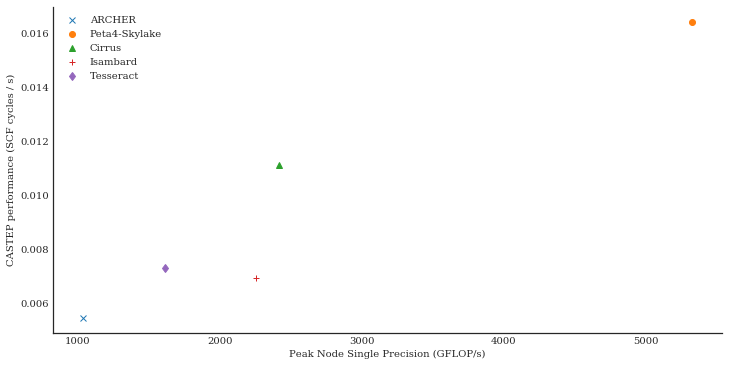

In [58]:
n=0
for system in castep_systems:
    if system in peak_bw:
        plt.plot(peak_fp.get(system,0.0),castep_perf.get(system,0.0),marker_a[n],label=system)
        n += 1
plt.xlabel('Peak Node Single Precision (GFLOP/s)')
plt.ylabel('CASTEP performance (SCF cycles / s)')
plt.legend(loc='best')
sns.despine()
plt.savefig('castep_corr.png', dpi=300)
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(castep_perf_a, fp_perf_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(castep_perf_a, fp_perf_a)[0]))

These analyses suggest a strong correlation between the peak floating point performance of the compute nodes and the performance of the CASTEP benchmark. The correlation for this CASTEP benchmark is stronger than the correlation for GROMACS; which is traditionally though of a pure floating point application. This is probably due to the fact that, on a single node, most of the time for this CASTEP benchmark is spent in LAPACK numerical routines which are well-optimed to exploit the maximum floating point performance from the processors. The system furthest from the correlation line is Isambard (Marvell Arm ThunderX2) impying that this system is not exploiting the floating point performance as well as the other systems.

### Correlation to peak memory performance

Below we compute the correlation coefficients for the CASTEP benchmark performance compared to memory performance, both in terms of peak bandwdth and in terms of the number of memory channels. As for the floating point correlation analysis, we perform two correlation tests: a Pearson correlation test and a Spearman rank-order correlation test.

In [59]:
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(castep_bw_a, peak_bw_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(castep_bw_a, peak_bw_a)[0]))

Pearson correlation coefficient =  0.223
Spearman rank-order correlation coefficient =  0.200


In [60]:
print('Pearson correlation coefficient = ', '{:.3f}'.format(stats.pearsonr(castep_bw_a, channels_a)[0]))
print('Spearman rank-order correlation coefficient = ', '{:.3f}'.format(stats.spearmanr(castep_bw_a, channels_a)[0]))

Pearson correlation coefficient =  -0.013
Spearman rank-order correlation coefficient =  0.053


The results for memory correlation suggest there is no correlation between node memory performance and the perfomance of this CASTEP benchmark on a single node.

### Performance comparison matrix

In [61]:
print("{:13s}".format(''),end='')
for jsystem in castep_systems:
    print("{:>14s}".format(jsystem), end='')
print()
for isystem in castep_systems:
    print("{:13s}".format(isystem), end='')
    iperf = castep_perf[isystem]
    for jsystem in castep_systems:
        jperf = castep_perf[jsystem]
        print("{:14.3f}".format(iperf/jperf), end='')
    print()

                     ARCHER Peta4-Skylake        Cirrus      Isambard     Tesseract
ARCHER                1.000         0.331         0.489         0.786         0.746
Peta4-Skylake         3.023         1.000         1.479         2.375         2.254
Cirrus                2.043         0.676         1.000         1.605         1.524
Isambard              1.273         0.421         0.623         1.000         0.949
Tesseract             1.341         0.444         0.656         1.054         1.000
